In [19]:
from pathlib import Path
import geopandas as gp
import xarray as xr
import rioxarray
import joblib
from hyspexutil.features import bandutil459 as bu

In [141]:
crownfile = Path('/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/HySpex_data_extracted/crowns_BC_all.gpkg')
crownROIfile = Path('/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/GIS/veg_locations/CW_test_poly.gpkg')

In [157]:
crowns = gp.GeoDataFrame.from_file(crownfile, layer="20210803-BC_03").overlay(gp.GeoDataFrame.from_file(crownROIfile, layer='crown_viz'), how='intersection')
crowns

,raster_x,raster_y,prefix_1,lineno,filename,id,prefix_2,linenumber,geometry
0,679.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437277.000 7176719.000)
1,697.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437295.000 7176719.000)
2,723.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437321.000 7176719.000)
3,838.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437436.000 7176719.000)
4,757.0,6335.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437355.000 7176718.000)
...,...,...,...,...,...,...,...,...,...
742,788.0,6482.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437386.000 7176571.000)
743,702.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437300.000 7176570.000)
744,772.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437370.000 7176570.000)
745,777.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437375.000 7176570.000)


In [80]:
def extract_spectra(df, startskip=0, endskip=0):
    end = len(df.columns)
    spectra_forcorr = df.loc[:, df.columns[startskip:end+1-endskip]]
    return spectra_forcorr.where(spectra_forcorr < 10000, 0.0)

In [158]:
testfile = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testDS = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})
testDS

<xarray.Dataset>
Dimensions:      (band: 459, x: 1226, y: 8506)
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.366e+05 4.366e+05 ... 4.378e+05 4.378e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 400, 200), meta=np.ndarray>

In [144]:
selected_bands = bu.mlbands
selected_band_idx = bu.mlbands_idx

In [121]:
modeldir = Path('/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/ML_models/singlepix_main_BCEF_2021.pkl')
model = joblib.load(modeldir)

In [159]:
crowns.prefix_1.value_counts()

20210803-BC    747
Name: prefix_1, dtype: int64

In [160]:
testcrowns = crowns
xs = xr.DataArray(testcrowns.geometry.x.values, dims='z')
ys = xr.DataArray(testcrowns.geometry.y.values, dims='z')

In [148]:
len(set(zip(xs.values, ys.values)))

45

In [161]:
testDS.band_data.sel(x=xs, y=ys, band=selected_bands[:-10], method="nearest").to_dataframe().reset_index()

,band,z,fwhm,wavelength,x,y,spatial_ref,band_data
0,282,0,6.52,1547.11,437277.0,7176719.0,0,1027.0
1,282,1,6.52,1547.11,437295.0,7176719.0,0,1241.0
2,282,2,6.52,1547.11,437321.0,7176719.0,0,1101.0
3,282,3,6.52,1547.11,437436.0,7176719.0,0,837.0
4,282,4,6.52,1547.11,437355.0,7176718.0,0,1810.0
...,...,...,...,...,...,...,...,...
22405,304,742,6.52,1666.67,437386.0,7176571.0,0,1306.0
22406,304,743,6.52,1666.67,437300.0,7176570.0,0,1974.0
22407,304,744,6.52,1666.67,437370.0,7176570.0,0,925.0
22408,304,745,6.52,1666.67,437375.0,7176570.0,0,1928.0


In [162]:
testDF_full = testDS.band_data.sel(x=xs, y=ys, band=selected_bands[:-10], method="nearest").to_dataframe().reset_index().pivot(
    index=['x', 'y'], columns=['band'], values='band_data').reset_index()
testDF = testDF_full.drop(columns=['x', 'y'])
testDF.columns = [f"band_{str(item).zfill(3)}" for item in testDF.columns]
testDF.where(testDF < 10000, 0.0)

,band_006,band_010,band_020,band_027,band_040,band_048,band_062,band_071,band_084,band_088,...,band_304,band_314,band_315,band_319,band_323,band_364,band_370,band_371,band_413,band_417
0,144.0,146.0,156.0,164.0,372.0,377.0,294.0,250.0,208.0,242.0,...,553.0,473.0,484.0,480.0,450.0,106.0,61.0,96.0,104.0,98.0
1,140.0,218.0,217.0,237.0,716.0,841.0,550.0,473.0,326.0,375.0,...,2485.0,2230.0,2219.0,2260.0,2069.0,561.0,593.0,618.0,1097.0,995.0
2,145.0,211.0,233.0,253.0,489.0,561.0,435.0,408.0,299.0,347.0,...,1437.0,1279.0,1248.0,1263.0,1169.0,280.0,297.0,354.0,586.0,489.0
3,180.0,241.0,262.0,284.0,533.0,611.0,499.0,447.0,343.0,389.0,...,1437.0,1296.0,1235.0,1260.0,1184.0,306.0,301.0,329.0,641.0,576.0
4,229.0,264.0,271.0,282.0,547.0,594.0,508.0,453.0,375.0,419.0,...,1475.0,1297.0,1261.0,1282.0,1176.0,271.0,304.0,394.0,594.0,484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,181.0,213.0,233.0,261.0,460.0,515.0,427.0,417.0,322.0,383.0,...,1146.0,1005.0,1006.0,999.0,939.0,138.0,216.0,311.0,309.0,395.0
743,101.0,117.0,183.0,193.0,514.0,581.0,400.0,338.0,254.0,295.0,...,1525.0,1362.0,1323.0,1352.0,1249.0,219.0,280.0,351.0,527.0,477.0
744,109.0,151.0,189.0,232.0,563.0,660.0,483.0,426.0,321.0,376.0,...,1510.0,1341.0,1321.0,1331.0,1224.0,186.0,311.0,335.0,553.0,467.0
745,100.0,117.0,173.0,199.0,605.0,717.0,496.0,434.0,328.0,365.0,...,1905.0,1683.0,1671.0,1678.0,1516.0,210.0,393.0,386.0,684.0,653.0


In [163]:
testDF = testDF.reindex(columns=model.feature_names_in_)
testDF

,band_282,band_010,band_230,band_088,band_239,band_364,band_107,band_071,band_314,band_413,...,band_319,band_284,band_020,band_236,band_062,band_315,band_153,band_370,band_027,band_304
0,377.0,146.0,1541.0,242.0,1399.0,106.0,2240.0,250.0,473.0,104.0,...,480.0,393.0,156.0,1516.0,294.0,484.0,2786.0,61.0,164.0,553.0
1,1905.0,218.0,4702.0,375.0,4402.0,561.0,4736.0,473.0,2230.0,1097.0,...,2260.0,2002.0,217.0,4670.0,550.0,2219.0,5321.0,593.0,237.0,2485.0
2,1025.0,211.0,2916.0,347.0,2708.0,280.0,2864.0,408.0,1279.0,586.0,...,1263.0,1076.0,233.0,2885.0,435.0,1248.0,3472.0,297.0,253.0,1437.0
3,1042.0,241.0,3032.0,389.0,2824.0,306.0,2929.0,447.0,1296.0,641.0,...,1260.0,1107.0,262.0,3028.0,499.0,1235.0,3521.0,301.0,284.0,1437.0
4,1059.0,264.0,3021.0,419.0,2787.0,271.0,3155.0,453.0,1297.0,594.0,...,1282.0,1105.0,271.0,2977.0,508.0,1261.0,3861.0,304.0,282.0,1475.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,837.0,213.0,2704.0,383.0,2463.0,138.0,3172.0,417.0,1005.0,309.0,...,999.0,881.0,233.0,2645.0,427.0,1006.0,4016.0,216.0,261.0,1146.0
743,1117.0,117.0,3491.0,295.0,3240.0,219.0,4163.0,338.0,1362.0,527.0,...,1352.0,1158.0,183.0,3447.0,400.0,1323.0,4828.0,280.0,193.0,1525.0
744,1107.0,151.0,3681.0,376.0,3343.0,186.0,4690.0,426.0,1341.0,553.0,...,1331.0,1150.0,189.0,3608.0,483.0,1321.0,5473.0,311.0,232.0,1510.0
745,1392.0,117.0,4188.0,365.0,3846.0,210.0,5177.0,434.0,1683.0,684.0,...,1678.0,1473.0,173.0,4115.0,496.0,1671.0,6112.0,393.0,199.0,1905.0


<AxesSubplot:>

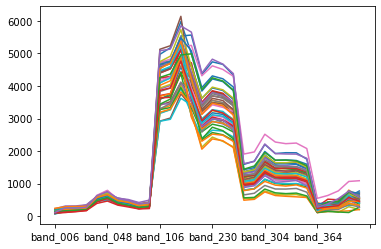

In [153]:
testDF.T.sort_index().plot(legend=False)

In [164]:
model.predict(testDF)

array(['white spruce', 'paper birch', 'quaking aspen', 'white spruce',
       'white spruce', 'white spruce', 'white spruce', 'white spruce',
       'quaking aspen', 'white spruce', 'quaking aspen', 'quaking aspen',
       'white spruce', 'white spruce', 'paper birch', 'quaking aspen',
       'white spruce', 'white spruce', 'white spruce', 'white spruce',
       'black spruce', 'black spruce', 'white spruce', 'white spruce',
       'quaking aspen', 'white spruce', 'white spruce', 'white spruce',
       'black spruce', 'white spruce', 'white spruce', 'white spruce',
       'black spruce', 'white spruce', 'quaking aspen', 'white spruce',
       'black spruce', 'quaking aspen', 'white spruce', 'quaking aspen',
       'paper birch', 'quaking aspen', 'white spruce', 'white spruce',
       'white spruce', 'white spruce', 'white spruce', 'white spruce',
       'white spruce', 'paper birch', 'quaking aspen', 'quaking aspen',
       'white spruce', 'white spruce', 'white spruce', 'white spruce'

In [165]:
crowns['species'] = model.predict(testDF)
crowns

,raster_x,raster_y,prefix_1,lineno,filename,id,prefix_2,linenumber,geometry,species
0,679.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437277.000 7176719.000),white spruce
1,697.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437295.000 7176719.000),paper birch
2,723.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437321.000 7176719.000),quaking aspen
3,838.0,6334.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437436.000 7176719.000),white spruce
4,757.0,6335.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437355.000 7176718.000),white spruce
...,...,...,...,...,...,...,...,...,...,...
742,788.0,6482.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437386.000 7176571.000),quaking aspen
743,702.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437300.000 7176570.000),paper birch
744,772.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437370.000 7176570.000),paper birch
745,777.0,6483.0,20210803-BC,03,20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop...,1,20200830-BC,04,POINT (437375.000 7176570.000),paper birch


In [166]:
outdir = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/Classified_output")
crowns.to_file(outdir / "crowns_BC_classified_test.gpkg", driver="GPKG", layer="20210803-BC_03")

In [17]:
sorted(hex20_df.vegclass.unique())

['Bare Ground',
 'Black Spruce Woodland with Tussocks',
 'Black Spruce/Tamarack Forest',
 'Closed Black Spruce Forest',
 'Closed Paper Birch Forest',
 'Closed Quaking Aspen Forest',
 'Closed Quaking Aspen/White Spruce Forest',
 'Closed Spruce/Paper Birch Forest',
 'Closed Spruce/Paper Birch/Aspen Forest',
 'Closed Tall Alder',
 'Closed Tall Birch/Willow Shrub',
 'Closed White Spruce Forest',
 'Open Black Spruce Forest',
 'Open Quaking Aspen/Spruce Forest',
 'Open Spruce/Paper Birch Forest',
 'Open Tall Alder Shrub',
 'Open Tall Birch Shrub',
 'Open White Spruce Forest',
 'Water',
 'Wet Sedge Meadow']

In [12]:
hex20_df.groupby(by=['vegclass'])['vegclass'].count()

vegclass
Bare Ground                                  6
Black Spruce Woodland with Tussocks          6
Black Spruce/Tamarack Forest                11
Closed Black Spruce Forest                   6
Closed Paper Birch Forest                    6
Closed Quaking Aspen Forest                  8
Closed Quaking Aspen/White Spruce Forest     9
Closed Spruce/Paper Birch Forest            11
Closed Spruce/Paper Birch/Aspen Forest       3
Closed Tall Alder                            3
Closed Tall Birch/Willow Shrub               3
Closed White Spruce Forest                   6
Open Black Spruce Forest                    21
Open Quaking Aspen/Spruce Forest             6
Open Spruce/Paper Birch Forest               9
Open Tall Alder Shrub                        6
Open Tall Birch Shrub                        3
Open White Spruce Forest                     6
Water                                        5
Wet Sedge Meadow                            10
Name: vegclass, dtype: int64

----

### Random sample polygon

In [106]:
ii = np.random.randint(len(hex20_df))
samplepoly = hex20_df.iloc[ii]
samplepoly

id                                                      137118
left                                             438740.543092
top                                               7175623.7406
right                                            438763.637103
bottom                                            7175603.7406
vegclass                            Closed Black Spruce Forest
flighline                                                   01
geometry     POLYGON ((438740.54309229605 7175613.7406, 438...
Name: 109, dtype: object

In [47]:
samplepoly.flighline

'07'

In [107]:
fn = HySpexPth / dirprefix /  subpath / f"{dirprefix.replace('_', '-')}_{samplepoly.flighline}_{filepatt}"
print(fn, 'ok' if fn.exists() else 'does not exist')

/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_01_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq ok


In [108]:
np.floor(samplepoly.left)

438740.0

In [109]:
print(samplepoly.geometry.centroid.xy)

(array('d', [438752.0900976798]), array('d', [7175613.740599999]))


In [113]:
xs = np.arange(np.floor(samplepoly.left), np.ceil(samplepoly.right) + 1.0)
ys = np.arange(np.floor(samplepoly.bottom), np.ceil(samplepoly.top) + 1.0)
x_ds = xr.DataArray(xs, dims=['x'])
y_ds = xr.DataArray(ys, dims=['y'])
pts = [Point(x, y) for x in xs for y in ys if Point(x, y).within(samplepoly.geometry)]
len(pts)

347

In [115]:
with xr.open_dataset(fn, engine='rasterio') as ds:
   sel = ds.sel(x=x_ds, y=y_ds)
sel.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (band: 459, x: 25, y: 22)
Coordinates:
    fwhm         (band) float64 ...
    wavelength   (band) float64 ...
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.387e+05 4.387e+05 ... 4.388e+05 4.388e+05
  * y            (y) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...>

In [40]:
clipped = rioxarray.open_rasterio(fn, masked=True).rio.clip([samplepoly.geometry], from_disk=True)

In [41]:
clipped

<xarray.DataArray (band: 459, y: 21, x: 24)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 4.349e+05 4.349e+05 4.349e+05 ... 4.35e+05 4.35e+05
  * y            (y) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
    fwhm         (band) float64 3.8 3.8 3.8 3.8 3.8 ... 6.52 6.52 6.52 6.52 6.52
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
    wavelength   (band) float64 410.4 413.5 416.7 ... 2.504e+03 2.509e+03
    spatial_ref  int64 0
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('band   1 (410.36 nm)', 'band   2 (413.53 nm)...
    acquisition_time:          2021-08-03T21:37:15.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 434307.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1203
    sun_azimuth:               172.78
    sun_elevation:             42.51
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [85]:
selected_band_idx = np.array([284,
 1,
 235,
 346,
 152,
 311,
 49,
 238,
 364,
 119,
 87,
 250,
 409,
 117,
 361,
 189,
 54,
 303,
 218,
 85,
 252,
 149,
 362,
 173,
 428,
 14,
 217,
 260,
 104,
 368,
 96,
 421,
 9,
 218,
 330,
 107,
 431,
 41,
 253,
 187,
 349,
 92,
 312,
 33,
 407,
 157,
 370,
 27,
 217])

In [98]:
stacked = clipped.sel(band=(selected_band_idx[:-10] + 1)).stack(desired=['x', 'y'])
stacked

<xarray.DataArray (band: 39, desired: 504)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    fwhm         (band) float64 6.52 3.8 6.52 6.52 3.8 ... 3.8 6.52 3.81 6.52
  * band         (band) int64 285 2 236 347 153 312 ... 219 331 108 432 42 254
    wavelength   (band) float64 1.563e+03 413.5 1.297e+03 ... 540.3 1.395e+03
    spatial_ref  int64 0
  * desired      (desired) MultiIndex
  - x            (desired) float64 4.349e+05 4.349e+05 ... 4.35e+05 4.35e+05
  - y            (desired) float64 7.176e+06 7.176e+06 ... 7.176e+06 7.176e+06
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('band   1 (410.36 nm)', 'band   2 (413.53 nm)...
    acquisition_time:          2021-08-03T21:37:15.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 434307.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1203
    sun_azimuth:               172.78
    sun_elevation:             42.51
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [99]:
valdf = stacked.to_dataframe(name='band').dropna().drop(labels=['fwhm', 'wavelength', 'spatial_ref'], axis=1).rename(columns={'band': 'reflectance'})
valdf

reflectance
band x        y                     
285  434931.0 7175615.0        628.0
              7175614.0        765.0
              7175613.0        576.0
     434932.0 7175617.0        807.0
              7175616.0        626.0
...                              ...
254  434951.0 7175611.0        695.0
     434952.0 7175615.0        777.0
              7175614.0        540.0
              7175613.0        519.0
              7175612.0        745.0

[13455 rows x 1 columns]

In [100]:
valdf.reset_index().band.unique()

array([285,   2, 236, 347, 153, 312,  50, 239, 365, 120,  88, 251, 410,
       118, 362, 190,  55, 304, 219,  86, 253, 150, 363, 174, 429,  15,
       218, 261, 105, 369,  97, 422,  10, 331, 108, 432,  42, 254])

In [101]:
valdf

reflectance
band x        y                     
285  434931.0 7175615.0        628.0
              7175614.0        765.0
              7175613.0        576.0
     434932.0 7175617.0        807.0
              7175616.0        626.0
...                              ...
254  434951.0 7175611.0        695.0
     434952.0 7175615.0        777.0
              7175614.0        540.0
              7175613.0        519.0
              7175612.0        745.0

[13455 rows x 1 columns]

In [102]:
valdf.index[valdf.index.duplicated()].unique()

MultiIndex([(219, 434931.0, 7175615.0),
            (219, 434931.0, 7175614.0),
            (219, 434931.0, 7175613.0),
            (219, 434932.0, 7175617.0),
            (219, 434932.0, 7175616.0),
            (219, 434932.0, 7175615.0),
            (219, 434932.0, 7175614.0),
            (219, 434932.0, 7175613.0),
            (219, 434932.0, 7175612.0),
            (219, 434932.0, 7175611.0),
            ...
            (219, 434951.0, 7175616.0),
            (219, 434951.0, 7175615.0),
            (219, 434951.0, 7175614.0),
            (219, 434951.0, 7175613.0),
            (219, 434951.0, 7175612.0),
            (219, 434951.0, 7175611.0),
            (219, 434952.0, 7175615.0),
            (219, 434952.0, 7175614.0),
            (219, 434952.0, 7175613.0),
            (219, 434952.0, 7175612.0)],
           names=['band', 'x', 'y'], length=345)

In [103]:
valdf.reset_index().pivot(index=['x', 'y'], columns='band', values='reflectance')

ValueError: Index contains duplicate entries, cannot reshape

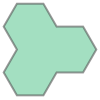

In [32]:
samplepoly = hex20_df.iloc[6].geometry
samplepoly